In [18]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
import numpy as np

In [2]:
# This is a function for creating unique id for each node

node_ids = set()

def generate_node_id(node_ids):
    new_id = random.randint(1, 1e5)
    while new_id in node_ids:
        new_id = random.randint(1, 1e5)
    node_ids.add(new_id)
    return new_id

In [3]:
# State capture per density_threshold

# By capturing the tree structure at each threshold, 
# you can see how features like connected components emerge, evolve, and disappear.
# This provides insights into the tree's resilience, adaptability, and the significance of its structural features.
# In the case of tree data structure, there is no hole so only connected dots (B_0) is considered

# Depth Threshold

depth_threshold = 3

# Degree/Density Threshold

density_thresholds = list(range(0, 4097, 16)) # [0, 16, 32, ..., 4096]

In [4]:
# Visualization function

def visualize_octree(data, source_id, depth, density_threshold, betti_0, octree):
    # Base case
    if depth == depth_threshold or len(data) == 0:
        return betti_0, octree
    
    # Calculate the boundaries
    min_x, max_x = data['X'].min(), data['X'].max()
    min_y, max_y = data['Y'].min(), data['Y'].max()
    min_z, max_z = data['Z'].min(), data['Z'].max()

    # Calculate midpoints
    mid_x = (max_x + min_x) / 2
    mid_y = (max_y + min_y) / 2
    mid_z = (max_z + min_z) / 2

    # The eight octants in 3D space
    subdivisions = [
        (data['X'] <= mid_x) & (data['Y'] <= mid_y) & (data['Z'] <= mid_z),
        (data['X'] <= mid_x) & (data['Y'] <= mid_y) & (data['Z'] > mid_z),
        (data['X'] <= mid_x) & (data['Y'] > mid_y) & (data['Z'] <= mid_z),
        (data['X'] <= mid_x) & (data['Y'] > mid_y) & (data['Z'] > mid_z),
        (data['X'] > mid_x) & (data['Y'] <= mid_y) & (data['Z'] <= mid_z),
        (data['X'] > mid_x) & (data['Y'] <= mid_y) & (data['Z'] > mid_z),
        (data['X'] > mid_x) & (data['Y'] > mid_y) & (data['Z'] <= mid_z),
        (data['X'] > mid_x) & (data['Y'] > mid_y) & (data['Z'] > mid_z),
    ]

    # We are reaching further depth
    depth += 1

    for subdivision in subdivisions:
        filtered_data = data[subdivision]
        num_points_in_box = len(filtered_data)
        
        target_id = generate_node_id(node_ids)
        
        # Create box to hold each piece of data
        box = [num_points_in_box, depth, source_id, target_id]
        
        # Store box info
        if num_points_in_box > density_threshold:
            octree.append(box)
            betti_0, octree = visualize_octree(filtered_data, target_id, depth, density_threshold, betti_0, octree)
        else:
            betti_0 += 1

    return betti_0, octree

# $Betti_0$

### Why examine change in $Betti_0$ with across density thresholds? -

### (1) Analyze how tree data structure's topplogy evolves as a condition (i.e., density thresholds) is applied 

### (2) Understand the shape of the input data across scales - provides insights into the data structure's resilience, adaptability, and the significance of its structural features

### Why only $Betti_0$ is examined - tree data structures don't create loop

### Why density thresholds? - maybe to provide insights to customize tree data structure (e.g., the greater the density threshold the less data a tree data structure stores yet the faster that data structure is created; the problem is - does it preserve the original features of the input data?)

<br>

### (3**) Visualize which features of the input data are robust across a range of conditions (i.e., different density thresholds)

### (4**) Understand how well a tree structure adapts to varying densities

### (5**) Build Speed across Density Thresholds 

### (6**) Octree vs. K-D Tree

<br>

### Zhonghao will provide Search Speeds next week

# Veritical Comparison

## $Betti_0$ Change in House Point Clouds Across Octree Density Thresholds

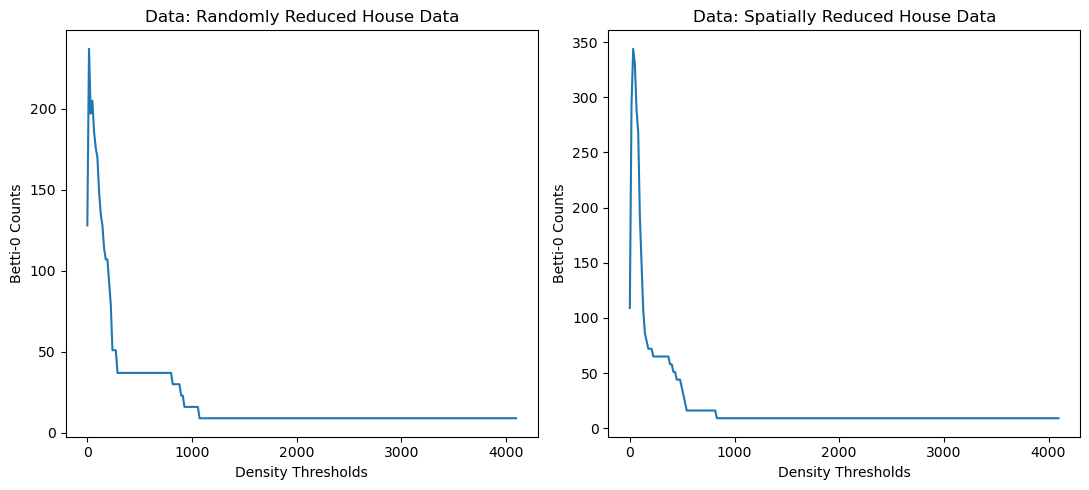

In [10]:
# Read the data for House Random

data_random = pd.read_csv('data/House/csv/random/house_random.csv', sep=',')[['X', 'Y', 'Z']]
house_random_betti_0s = []

for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    octree = [] # for storing the whole octree
    betti_0, octree = visualize_octree(data_random, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       octree)
    house_random_betti_0s.append(betti_0)

# Read the data for House Spatial

data_spatial = pd.read_csv('data/House/csv/spatial/house_spatial.csv', sep=',')[['X', 'Y', 'Z']]
house_spatial_betti_0s = []

for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    octree = [] # for storing the whole octree
    betti_0, octree = visualize_octree(data_spatial, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       octree)
    house_spatial_betti_0s.append(betti_0)

# Visualizations

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))

# Plot for House Random

axs[0].plot(density_thresholds, house_random_betti_0s)
axs[0].set_xlabel('Density Thresholds')
axs[0].set_ylabel('Betti-0 Counts')
axs[0].set_title('Data: Randomly Reduced House Data')


# Plot for House Spatial

axs[1].plot(density_thresholds, house_spatial_betti_0s)
axs[1].set_xlabel('Density Thresholds')
axs[1].set_ylabel('Betti-0 Counts')
axs[1].set_title('Data: Spatially Reduced House Data')

plt.tight_layout()
plt.show()

## Variances of Among the Two Distributions - How Much Did $Betti_0s$ Change In Each Case?

In [19]:
var_house_random = np.var(np.array(house_random_betti_0s))
var_house_spatial = np.var(np.array(house_spatial_betti_0s))

print(var_house_random, var_house_spatial)

1198.955623855017 2093.068085815078


## Wasserstein Distance Between the Two Distribution - How Different They Are?

In [14]:
was_dis_house = wasserstein_distance(house_random_betti_0s, house_spatial_betti_0s)
print(was_dis_house)

6.385214007782104


## $Betti_0$ Change in Tree Point Clouds Across Octree Density Thresholds

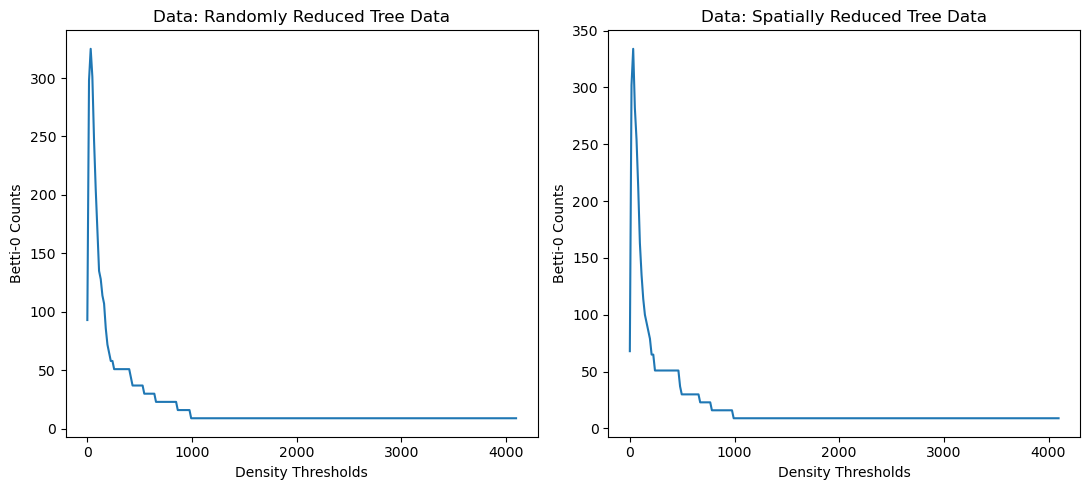

In [6]:
# Read the data for Tree Random

data_random = pd.read_csv('data/Tree/csv/random/tree_random.csv', sep=',')[['X', 'Y', 'Z']]
tree_random_betti_0s = []

for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    octree = [] # for storing the whole octree
    betti_0, octree = visualize_octree(data_random, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       octree)
    tree_random_betti_0s.append(betti_0)

# Read the data for Tree Spatial

data_spatial = pd.read_csv('data/Tree/csv/spatial/tree_spatial.csv', sep=',')[['X', 'Y', 'Z']]
tree_spatial_betti_0s = []

for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    octree = [] # for storing the whole octree
    betti_0, octree = visualize_octree(data_spatial, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       octree)
    tree_spatial_betti_0s.append(betti_0)

# Visualizations

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))

# Plot for Tree Random

axs[0].plot(density_thresholds, tree_random_betti_0s)
axs[0].set_xlabel('Density Thresholds')
axs[0].set_ylabel('Betti-0 Counts')
axs[0].set_title('Data: Randomly Reduced Tree Data')


# Plot for Tree Spatial

axs[1].plot(density_thresholds, tree_spatial_betti_0s)
axs[1].set_xlabel('Density Thresholds')
axs[1].set_ylabel('Betti-0 Counts')
axs[1].set_title('Data: Spatially Reduced Tree Data')

plt.tight_layout()
plt.show()

## Variances of Among the Two Distributions - How Much Did $Betti_0s$ Change In Each Case?

In [21]:
var_tree_random = np.var(np.array(tree_random_betti_0s))
var_tree_spatial = np.var(np.array(tree_spatial_betti_0s))

print(var_tree_random, var_tree_spatial)

1757.931293433663 1733.9757452800188


## Wasserstein Distance Between the Two Distribution - How Different They Are?

In [15]:
was_dis_tree = wasserstein_distance(tree_random_betti_0s, tree_spatial_betti_0s)
print(was_dis_tree)

0.9066147859922182


## $Betti_0$ Change in Light Pole Point Clouds Across Octree Density Thresholds

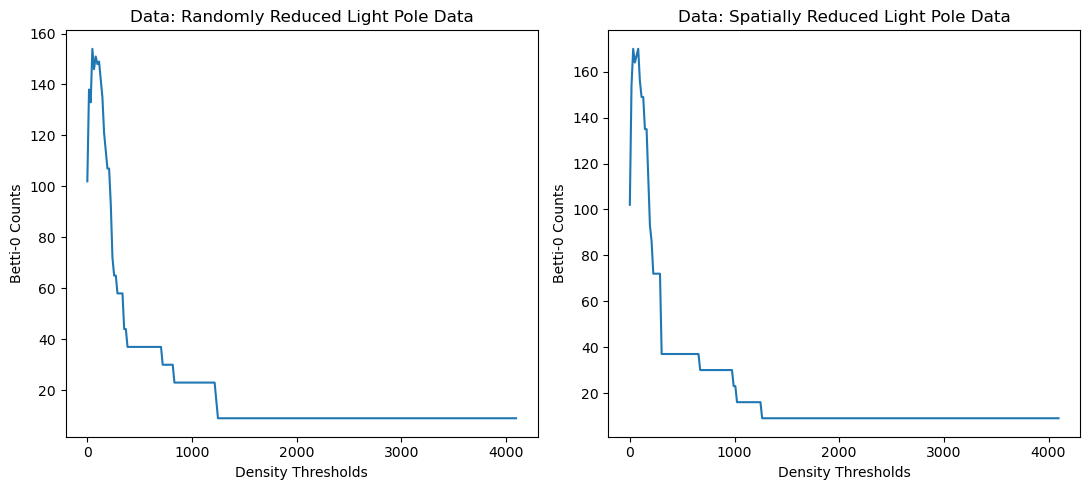

In [9]:
# Read the data for Light Pole Random

data_random = pd.read_csv('data/LightPole/csv/random/lightpole_random.csv', sep=',')[['X', 'Y', 'Z']]
lightpole_random_betti_0s = []

for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    oclightpole = [] # for storing the whole oclightpole
    betti_0, oclightpole = visualize_octree(data_random, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       oclightpole)
    lightpole_random_betti_0s.append(betti_0)

# Read the data for Light Pole Spatial

data_spatial = pd.read_csv('data/LightPole/csv/spatial/lightpole_spatial.csv', sep=',')[['X', 'Y', 'Z']]
lightpole_spatial_betti_0s = []

for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    oclightpole = [] # for storing the whole oclightpole
    betti_0, oclightpole = visualize_octree(data_spatial, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       oclightpole)
    lightpole_spatial_betti_0s.append(betti_0)

# Visualizations

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))

# Plot for Light Pole Random

axs[0].plot(density_thresholds, lightpole_random_betti_0s)
axs[0].set_xlabel('Density Thresholds')
axs[0].set_ylabel('Betti-0 Counts')
axs[0].set_title('Data: Randomly Reduced Light Pole Data')


# Plot for Light Pole Spatial

axs[1].plot(density_thresholds, lightpole_spatial_betti_0s)
axs[1].set_xlabel('Density Thresholds')
axs[1].set_ylabel('Betti-0 Counts')
axs[1].set_title('Data: Spatially Reduced Light Pole Data')

plt.tight_layout()
plt.show()

## Variances of Among the Two Distributions - How Much Did $Betti_0s$ Change In Each Case?

In [22]:
mean = np.mean(data)
std_dev = np.std(data)

var_lightpole_random = np.var(np.array(lightpole_random_betti_0s))
var_lightpole_spatial = np.var(np.array(lightpole_spatial_betti_0s))

print(var_lightpole_random, var_lightpole_spatial)

880.8675680176841 979.5818256143164


## Wasserstein Distance Between the Two Distribution - How Different They Are?

In [25]:
was_dis_lightpole = wasserstein_distance(lightpole_random_betti_0s, lightpole_spatial_betti_0s)
print(was_dis_lightpole)

1.8754863813229592


# Horizontal Comparison

## Comparison Among Z-Score Normalized Varainces

In [36]:
var = np.array([var_house_random, var_house_spatial, \
                var_tree_random, var_tree_spatial, \
                var_lightpole_random, var_lightpole_spatial])
var_normal = (var - np.mean(var)) / np.std(var)

print(abs(var_normal))

[0.54136592 1.46067405 0.71025698 0.65661724 1.25360854 1.03257383]


| Input Data |Variances|
| -| - |
| House (Random)  | 0.54136592  |
| House (Spatial) | 1.46067405  |
| Tree (Random) | 0.71025698  |
| Tree (Spatial) | 0.65661724  |
| Light Pole (Random) | 1.25360854  |
| Light Pole (Spatial) | 1.03257383  |

## Comparison Among Z-Score Normalized Wasserstein Distances

In [37]:
was_dis = np.array([was_dis_house, was_dis_tree, was_dis_lightpole])

was_dis_normal = (was_dis - np.mean(was_dis)) / np.std(was_dis)

print(abs(was_dis_normal))

[1.39466675 0.9002582  0.49440855]


| Input Data |Normalized Wasserstein Distance|
| -| - |
| House | 1.39466675  |
| Tree | 0.9002582  |
| Light Pole | 0.49440855 |

# What do these numbers potentially show?

### (1) Comparatively Greater Variance difference between House(Random) and House(Spatial) data
### (2) Subsample choice matters for reducing House Data
### (3) Assumption: Spatial Subsampling preserves more of the original house structure <br><br>That being said: Spatial subsampling recommended for storing house point cloud data although it is a lot slower.
### (5) Random and Spatial Subsampling methods works comparatively well for both Tree (comparatively ill structured) and Light Pole (comparatively well structured) data. <br><br> That being said: Random Subsamling method is recommended since it is a lot faster

# What do these numbers further show?

## ~house point cloud...

## (1) Observation

### (1.1) Wasserstein distance between the topological graph of how $betti_0$ changes using two house data is the largest. 

### - Why? <br> -- Maybe because the variance of the two house data is the large, which means that the input house data aren't similar to each other, so their topo graphs wouldn't be similar either

## (2) Next step questions: 

### - Which part of the house got discarded? <br> -- Probably the non-roof part.

### - How? <br> -- Not enough points in most of the octants to pass the density threshold.

### - What is the result of this? <br> -- If one wants to search for any points near the base of the house, one would not find them if the density threshold is set too high when storing the house data.

### - Any suggestion can be made? <br> -- Either the density threshold shouldn't be large, or one should use a spatial subsampling method to reduce the house data (if wanting a faster and better storage).

<br>

## ~light pole & tree point cloud

## (1) Observations

### (1.1) The variance of two light pole data isn't the smallest, yet the Wasserstein distance between them is the shortest.

### Why? <br> -- The very "obvious" and organized geometry of light poles makes their structure hard to get destroyed in either random or spatial subsampling.

### (1.2) The Wasserstein distance between two tree data sets is long (double that of the light pole).

### Why? <br> -- Not all leaf areas have an equal density of points, so some leaf areas are discarded by the density threshold earlier, and that makes a big(?) difference between storing two kinds of tree data in an octree.

### (1.3) Both of the light pole octrees' topo graphs are comparatively smoother (i.e., the change in octree structure is less drastic with different density thresholds).

### Why? <br> -- Due to the slender feature of the light pole in addition to the inclusion of the base/ground part in its point cloud data file, so more points are concentrated in fewer octants of the octree. Therefore, fewer octants or significant points that preserve the structure of a light pole might get discarded even when the density threshold is high, when storing it in an octree.


## (2) Next step questions: 

### - Which part of the light pole or tree got discarded? <br> -- Ground/Base area (light pole); Leaf area (tree).

### - How? <br><br> -- The area where points are more compacted (which makes the density of an octant high) isn't going to get discarded quickly.

### - What is the result of this? <br> -- If one wants to search for any points near the base of the house, one would not find them if the density threshold is set too high when storing the house data.

### - Any suggestion can be made? <br><br> -- When storing light pole point cloud -- include its base/ground area, set the density threshold high (so the base/ground area gets discarded first), use random reduction, the storage speed may be faster and the memory usage may be low. <br><br> -- When storing tree point cloud -- it has to be clear on whether the density distribution in the foliage area is important. If not, then random reduction + somewhat high density threshold isn't a bad choice.

finally, regarding the hytrospectrum project...

# Re-do the density threshold part.. but with less thresholds so the graph should be more clear

In [38]:
# State capture per density_threshold

# By capturing the tree structure at each threshold, 
# you can see how features like connected components emerge, evolve, and disappear.
# This provides insights into the tree's resilience, adaptability, and the significance of its structural features.
# In the case of tree data structure, there is no hole so only connected dots (B_0) is considered

# Depth Threshold

depth_threshold = 3

# Degree/Density Threshold

density_thresholds = [0, 1, pow(2,3), pow(2*2, 3), pow(2*2*2, 3), pow(2*2*2*2, 3)] # [0, 1, 8, 64, 512, 4096]

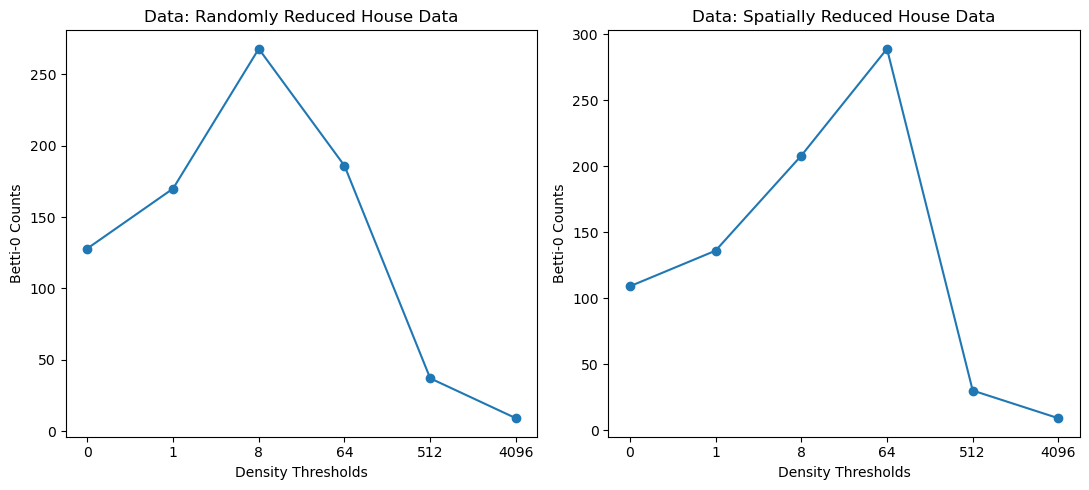

In [39]:
# Read the data for House Random

data_random = pd.read_csv('data/House/csv/random/house_random.csv', sep=',')[['X', 'Y', 'Z']]
house_random_betti_0s = []

for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    octree = [] # for storing the whole octree
    betti_0, octree = visualize_octree(data_random, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       octree)
    house_random_betti_0s.append(betti_0)

# Read the data for House Spatial

data_spatial = pd.read_csv('data/House/csv/spatial/house_spatial.csv', sep=',')[['X', 'Y', 'Z']]
house_spatial_betti_0s = []

for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    octree = [] # for storing the whole octree
    betti_0, octree = visualize_octree(data_spatial, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       octree)
    house_spatial_betti_0s.append(betti_0)

# Visualizations

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))

# Plot for House Random

axs[0].plot([0, 1, 2, 3, 4, 5], house_random_betti_0s, linestyle='-', marker='o')
axs[0].set_xticks([0, 1, 2, 3, 4, 5])
axs[0].set_xticklabels(density_thresholds)
axs[0].set_xlabel('Density Thresholds')
axs[0].set_ylabel('Betti-0 Counts')
axs[0].set_title('Data: Randomly Reduced House Data')


# Plot for House Spatial

axs[1].plot([0, 1, 2, 3, 4, 5], house_spatial_betti_0s, linestyle='-', marker='o')
axs[1].set_xticks([0, 1, 2, 3, 4, 5])
axs[1].set_xticklabels(density_thresholds)
axs[1].set_xlabel('Density Thresholds')
axs[1].set_ylabel('Betti-0 Counts')
axs[1].set_title('Data: Spatially Reduced House Data')

plt.tight_layout()
plt.show()

In [48]:
var_house_random = np.var(np.array(house_random_betti_0s))
var_house_spatial = np.var(np.array(house_spatial_betti_0s))

print(var_house_random, var_house_spatial)

7836.666666666667 9413.805555555557


In [49]:
was_dis_house = wasserstein_distance(house_random_betti_0s, house_spatial_betti_0s)
print(was_dis_house)

17.166666666666664


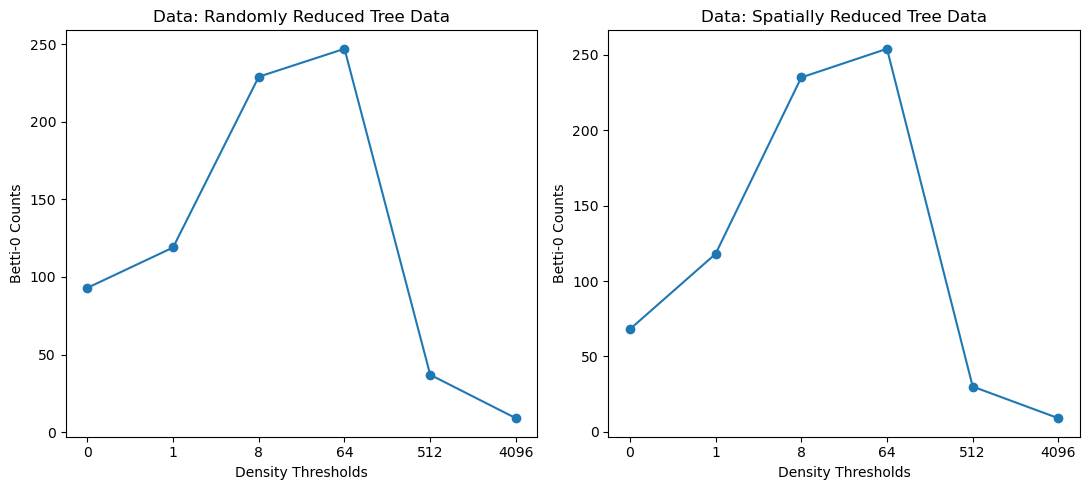

In [43]:
# Read the data for Tree Random

data_random = pd.read_csv('data/Tree/csv/random/tree_random.csv', sep=',')[['X', 'Y', 'Z']]
tree_random_betti_0s = []

for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    octree = [] # for storing the whole octree
    betti_0, octree = visualize_octree(data_random, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       octree)
    tree_random_betti_0s.append(betti_0)

# Read the data for Tree Spatial

data_spatial = pd.read_csv('data/Tree/csv/spatial/tree_spatial.csv', sep=',')[['X', 'Y', 'Z']]
tree_spatial_betti_0s = []

for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    octree = [] # for storing the whole octree
    betti_0, octree = visualize_octree(data_spatial, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       octree)
    tree_spatial_betti_0s.append(betti_0)

# Visualizations

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))

# Plot for Tree Random

axs[0].plot([0, 1, 2, 3, 4, 5], tree_random_betti_0s, linestyle='-', marker='o')
axs[0].set_xticks([0, 1, 2, 3, 4, 5])
axs[0].set_xticklabels(density_thresholds)
axs[0].set_xlabel('Density Thresholds')
axs[0].set_ylabel('Betti-0 Counts')
axs[0].set_title('Data: Randomly Reduced Tree Data')


# Plot for Light Pole Spatial

axs[1].plot([0, 1, 2, 3, 4, 5], tree_spatial_betti_0s, linestyle='-', marker='o')
axs[1].set_xticks([0, 1, 2, 3, 4, 5])
axs[1].set_xticklabels(density_thresholds)
axs[1].set_xlabel('Density Thresholds')
axs[1].set_ylabel('Betti-0 Counts')
axs[1].set_title('Data: Spatially Reduced Tree Data')

plt.tight_layout()
plt.show()

In [50]:
var_tree_random = np.var(np.array(tree_random_betti_0s))
var_tree_spatial = np.var(np.array(tree_spatial_betti_0s))

print(var_tree_random, var_tree_spatial)

7986.222222222223 9050.666666666666


In [51]:
was_dis_tree = wasserstein_distance(tree_random_betti_0s, tree_spatial_betti_0s)

print(was_dis_tree)

7.666666666666666


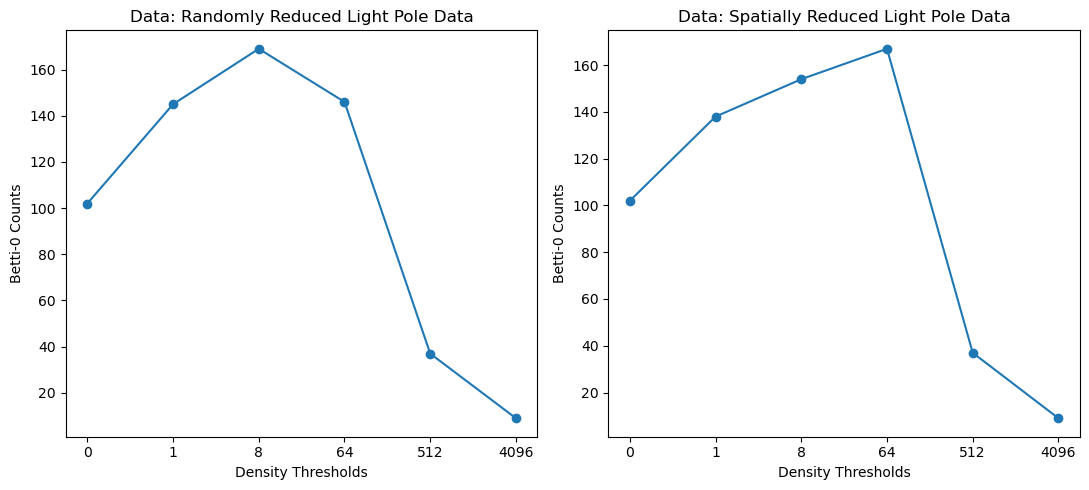

In [42]:
# Read the data for Light Pole Random

data_random = pd.read_csv('data/LightPole/csv/random/lightpole_random.csv', sep=',')[['X', 'Y', 'Z']]
lightpole_random_betti_0s = []

for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    oclightpole = [] # for storing the whole oclightpole
    betti_0, oclightpole = visualize_octree(data_random, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       oclightpole)
    lightpole_random_betti_0s.append(betti_0)

# Read the data for Light Pole Spatial

data_spatial = pd.read_csv('data/LightPole/csv/spatial/lightpole_spatial.csv', sep=',')[['X', 'Y', 'Z']]
lightpole_spatial_betti_0s = []

for density_threshold in density_thresholds:
    initial_source_id = 0 # the root
    initial_depth = 0 # the root is at depth 0
    initial_betti_0 = 1 # the root itself
    oclightpole = [] # for storing the whole oclightpole
    betti_0, oclightpole = visualize_octree(data_spatial, \
                                       initial_source_id, \
                                       initial_depth, \
                                       density_threshold, \
                                       initial_betti_0, \
                                       oclightpole)
    lightpole_spatial_betti_0s.append(betti_0)

# Visualizations

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))

# Plot for Light Pole Random

axs[0].plot([0, 1, 2, 3, 4, 5], lightpole_random_betti_0s, linestyle='-', marker='o')
axs[0].set_xticks([0, 1, 2, 3, 4, 5])
axs[0].set_xticklabels(density_thresholds)
axs[0].set_xlabel('Density Thresholds')
axs[0].set_ylabel('Betti-0 Counts')
axs[0].set_title('Data: Randomly Reduced Light Pole Data')


# Plot for Light Pole Spatial

axs[1].plot([0, 1, 2, 3, 4, 5], lightpole_spatial_betti_0s, linestyle='-', marker='o')
axs[1].set_xticks([0, 1, 2, 3, 4, 5])
axs[1].set_xticklabels(density_thresholds)
axs[1].set_xlabel('Density Thresholds')
axs[1].set_ylabel('Betti-0 Counts')
axs[1].set_title('Data: Spatially Reduced Light Pole Data')

plt.tight_layout()
plt.show()

In [52]:
mean = np.mean(data)
std_dev = np.std(data)

var_lightpole_random = np.var(np.array(lightpole_random_betti_0s))
var_lightpole_spatial = np.var(np.array(lightpole_spatial_betti_0s))

print(var_lightpole_random, var_lightpole_spatial)

3524.2222222222226 3515.805555555556


In [53]:
was_dis_lightpole = wasserstein_distance(lightpole_random_betti_0s, lightpole_spatial_betti_0s)

print(was_dis_lightpole)

2.833333333333334


In [55]:
var = np.array([var_house_random, var_house_spatial, \
                var_tree_random, var_tree_spatial, \
                var_lightpole_random, var_lightpole_spatial])
var_normal = (var - np.mean(var)) / np.std(var)

print(abs(var_normal))

[0.38814489 1.03335853 0.44932865 0.884797   1.37609289 1.37953618]


In [56]:
was_dis = np.array([was_dis_house, was_dis_tree, was_dis_lightpole])

was_dis_normal = (was_dis - np.mean(was_dis)) / np.std(was_dis)

print(abs(was_dis_normal))

[1.3342943  0.26126042 1.07303388]


### Export Files for Visualization in Gephi

In [ ]:
# octree_df = pd.DataFrame(octree, columns=['Degree', 'Depth', 'Source', 'Target'])

# # Edge
# # Source,Target,Type

# octree_df_edge = octree_df[['Source', 'Target']].copy()
# octree_df_edge['Type'] = 'Directed'

# # Node
# # Id,Degree(num_point),Depth

# octree_df_node = octree_df[['Target', 'Degree', 'Depth']]
# octree_df_node = octree_df_node.rename(columns={'Target': 'Id'})
# octree_df_node.loc[len(octree_df_node)] = {'Id': 0, 'Degree': 4096, 'Depth': 0} # append root node

# # export CSV

# octree_df_edge.to_csv('edge.csv', index = False)
# octree_df_node.to_csv('node.csv', index = False)